In [1]:
import numpy as np
from numpy import array, copy, full, concatenate, dot, vdot, kron, zeros, diag, sqrt, cos, sin, exp, arange, pi, sign, sort
from numpy.random import normal, uniform
from numpy.linalg import matrix_rank
from scipy.optimize import minimize
from functools import reduce
from numpy.random import choice
from time import time

import matplotlib.pyplot as plt

In [2]:
### QAOA code ###
### Thanks to Akshay Vishwanathan and Luis Ernesto Campos Espinoza! ###

def mixer_list(n):
    def split(x, k):
        return x.reshape((2**k, -1))
    def sym_swap(x):
        return np.asarray([x[-1], x[-2], x[1], x[0]])
    x_list = []
    t1 = np.asarray([arange(2**(n-1), 2**n), arange(0, 2**(n-1))])
    t1 = t1.flatten()
    x_list.append(t1.flatten())
    t2 = t1.reshape(4, -1)
    t3 = sym_swap(t2)
    t1 = t3.flatten()
    x_list.append(t1)
    k = 1
    while k < (n - 1):
        t2 = split(t1, k)
        t2 = np.asarray(t2)
        t1 = []
        for y in t2:
            t3 = y.reshape((4, -1))
            t4 = sym_swap(t3)
            t1.append(t4.flatten())
        t1 = np.asarray(t1)
        t1 = t1.flatten()
        x_list.append(t1)
        k += 1        
    return x_list

def apply_Hx(n, x_list, statevector):
    statevector_new = zeros(len(statevector), dtype=complex)
    for i in range(n):
        statevector_swap = statevector[x_list[i]]
        statevector_new = statevector_swap + statevector_new
    return statevector_new

def apply_H(H_diag, statevector):
    return H_diag*statevector

def apply_beta(n, x_list, beta, statevector):
    c = cos(beta)
    s = sin(beta)
    statevector_new = copy(statevector)
    for i in range(n):
        statevector_swap = statevector_new[x_list[i]]
        statevector_new = -1j*s*statevector_swap + c*statevector_new
    return statevector_new

def apply_gamma(H_diag, gamma, statevector):
    return exp(-1j*gamma*H_diag)*statevector

def qaoa_vec(pars, n, x_list, H_diag, state_ini):
    statevector = copy(state_ini)
    p = int(len(pars)/2)
    for j in range(p):
        k = 2*j
        statevector = apply_gamma(H_diag, pars[k], statevector)
        statevector = apply_beta(n, x_list, pars[k+1], statevector)
    return statevector

In [3]:
### QFI code ###
### Thanks to Andrey Kardashin! ###

def qaoa_qfi_matrix(pars, n, x_list, H_diag, state_ini):
    
    n_pars = len(pars)
    p = int(n_pars/2)
    QFI_matrix = zeros((n_pars, n_pars))
    
    statevector = copy(state_ini)
    statevectors_der = []
    
    for i in range(p):
        
        n_pars_i = 2*(i+1)
    
        statevector_der_gamma = -1j*apply_H(H_diag, statevector)
        statevector_der_gamma = apply_gamma(H_diag, pars[2*i], statevector_der_gamma)     
        statevector_der_gamma = apply_beta(n, x_list, pars[2*i+1], statevector_der_gamma)
        
        statevector = apply_gamma(H_diag, pars[2*i], statevector)     
        statevector = apply_beta(n, x_list, pars[2*i+1], statevector)
        
        statevector_der_beta = -1j*apply_Hx(n, x_list, statevector) 
        
        statevectors_der.append(statevector_der_gamma)
        statevectors_der.append(statevector_der_beta)
        
        for j in range(n_pars_i - 2):
            statevectors_der[j] = apply_gamma(H_diag, pars[2*i], statevectors_der[j])     
            statevectors_der[j] = apply_beta(n, x_list, pars[2*i+1], statevectors_der[j])     
            
        for a in range(n_pars_i):
            for b in range(n_pars_i - 2, n_pars_i):
                term_1 = vdot(statevectors_der[a], statevectors_der[b])
                term_2 = vdot(statevectors_der[a], statevector)*vdot(statevector, statevectors_der[b])
                QFI_ab = 4*(term_1 - term_2).real
                QFI_matrix[a][b] = QFI_matrix[b][a] = QFI_ab
            
    return QFI_matrix


def find_qaoa_eqd(x_list, n, H_diag, state_ini, tol=None, verbose=True):
    
    p = 1
    QFI_matrix = zeros((2, 2))
    pars = uniform(0, 2*pi, 2)
    max_rank = 0
    
    statevector = copy(state_ini)
    statevectors_der = []

    eqd_found = False
    while eqd_found == False and max_rank <= 2**(n + 1):

        if verbose == True:
            print("p_c: %5d | QFIM rank: %5d" % (p, max_rank), end="\r")
    
        n_pars = 2*p       

        statevector_der_gamma = -1j*apply_H(H_diag, statevector)
        statevector_der_gamma = apply_gamma(H_diag, pars[-2], statevector_der_gamma)     
        statevector_der_gamma = apply_beta(n, x_list, pars[-1], statevector_der_gamma)
        
        statevector = apply_gamma(H_diag, pars[-2], statevector)     
        statevector = apply_beta(n, x_list, pars[-1], statevector)
        
        statevector_der_beta = -1j*apply_Hx(n, x_list, statevector) 
        
        statevectors_der.append(statevector_der_gamma)
        statevectors_der.append(statevector_der_beta)
        
        for j in range(n_pars - 2):
            statevectors_der[j] = apply_gamma(H_diag, pars[-2], statevectors_der[j])     
            statevectors_der[j] = apply_beta(n, x_list, pars[-1], statevectors_der[j])     
            
        for a in range(n_pars):
            for b in range(n_pars - 2, n_pars):
                term_1 = vdot(statevectors_der[a], statevectors_der[b])
                term_2 = vdot(statevectors_der[a], statevector)*vdot(statevector, statevectors_der[b])
                QFI_ab = 4*(term_1 - term_2).real
                QFI_matrix[a][b] = QFI_matrix[b][a] = QFI_ab
            
        rank_p = matrix_rank(QFI_matrix, tol=tol, hermitian=True)
                                    
        if rank_p > max_rank:
            max_rank = rank_p
            QFI_matrix = np.append(QFI_matrix, zeros((n_pars, 2)), axis=1)
            QFI_matrix = np.append(QFI_matrix, zeros((2, n_pars + 2)), axis=0)
            pars = concatenate((pars, uniform(0, 2*pi, 2)))
            p += 1
        else:
            eqd_found = True
            QFI_matrix = QFI_matrix[:-2, :-2]
            p = int(max_rank/2)
            
    if verbose == True:
        print("p_c: %5d | QFIM rank: %5d" % (p, max_rank), end="\r")

    if max_rank > 2**(n + 1):
        print("\nQFIM rank is larger than 2**(n + 1)! Try to change tol.")

    return max_rank

In [4]:
### cost and callback ###

def fun(x):
    statevector = qaoa_vec(x, n, x_list, H_diag, state_ini)
    f = vdot(statevector, H_diag*statevector).real
    fval_cont[0] = f # for tracking the cost value 
    return f

def callback(x):
    fvals.append(fval_cont[0])
    if len(fvals)%10 == 0:
        print("\t\tIteration: %d | Cost: %.8f" %(len(fvals), fval_cont[0]), end="\r")
    return None

# MAX-CUT

In [109]:
import networkx as nx
from networkx.generators.random_graphs import erdos_renyi_graph

In [163]:
def edges_to_ham(n, edges):
    d = 2**n
    I_diag = array([1, 1])
    Z_diag = array([1, -1])
    H_diag = zeros(d, dtype=int)
    for edge in edges:
        if edge[0] != edge[1]:
            op = [I_diag]*n
            op[edge[0]] = Z_diag
            op[edge[1]] = Z_diag
            H_diag += reduce(kron, op)
    return H_diag

In [169]:
n = 5
p_min = 1
p_max = 2**n

d = 2**n
x_list = mixer_list(n)
state_ini = full(d, 1/sqrt(d))

p_c:     9 | QFIM rank:    18

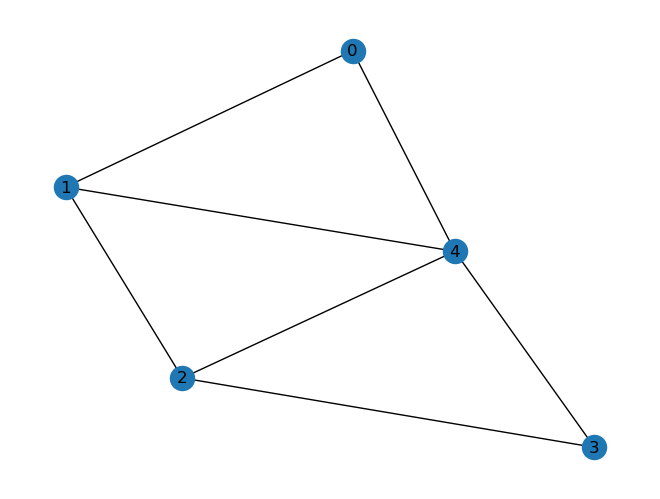

In [170]:
prob = 0.5

graph = erdos_renyi_graph(n, prob)
H_diag = edges_to_ham(n, list(graph.edges()))

### benchmark ###
# graph = nx.Graph([(0, 1), (1, 2), (2, 0), (2, 3)])
# H_diag = edges_to_ham(n, [(0, 1), (1, 2), (2, 0), (2, 3)])

cost_min_exact = min(H_diag)

p_c = int(find_qaoa_eqd(x_list, n, H_diag, state_ini, tol=None, verbose=True)/2)

nx.draw(graph, with_labels=True, pos=nx.spring_layout(graph, seed=1))

In [171]:
funs = zeros(p_max - p_min + 1)
errors = zeros(p_max - p_min + 1)
nits = zeros(p_max - p_min + 1)
nfevs = zeros(p_max - p_min + 1)
xfs = [zeros(2*p) for p in range(p_min, p_max + 1)]
times = zeros(p_max - p_min + 1)

fvals = []
fval_cont = [None]

x0 = uniform(0, 2*pi, 2*p_min)

c = 0
for p in range(p_min, p_max + 1):
    print("\tp:", p)
    
    time_start = time()
    result = minimize(x0=x0, fun=fun, callback=callback, method="BFGS")
    time_finish = time() - time_start
    xf = result.x
    error = abs(cost_min_exact - result.fun)

    print("\n\t\tFinished in %d seconds" %time_finish)
    print("\t\tError: %.9f" %error)
    
    funs[c:] = result.fun
    errors[c:] = error
    nits[c] = result.nit
    nfevs[c] = result.nfev
    times[c] = time_finish
    xfs[c] = result.x

    if abs(cost_min_exact - result.fun) <= 1e-8:
        print("Converged!")
        break
    else:
        c += 1
        x0 = concatenate([xf, uniform(0, 2*pi, 2)]) # simple initialization p -> p+1 random initialization
        ### interpolation initialization ###
        # gammas = result.x[::2]
        # betas = result.x[1::2]
        # gammas_next = zeros(p + 1)
        # betas_next = zeros(p + 1)
        # for j in range(p + 1):
        #     gammas_next[j] = j/p*gammas[j - 1] + (p - j)/p*gammas[j % p]
        #     betas_next[j] = j/p*betas[j - 1] + (p - j)/p*betas[j % p]
        # x0 = zeros(2*(p + 1))
        # x0[::2] = gammas_next
        # x0[1::2] = betas_next

	p: 1

		Finished in 0 seconds
		Error: 1.053180613
	p: 2
		Iteration: 20 | Cost: -2.42640065
		Finished in 0 seconds
		Error: 0.566613909
	p: 3
		Iteration: 30 | Cost: -2.69405570
		Finished in 0 seconds
		Error: 0.305019954
	p: 4
		Iteration: 50 | Cost: -2.94221200
		Finished in 0 seconds
		Error: 0.057780017
	p: 5
		Iteration: 110 | Cost: -2.82081588
		Finished in 0 seconds
		Error: 0.179181989
	p: 6
		Iteration: 220 | Cost: -2.95774170
		Finished in 0 seconds
		Error: 0.042258302
	p: 7
		Iteration: 260 | Cost: -2.95213845
		Finished in 0 seconds
		Error: 0.047861527
	p: 8
		Iteration: 360 | Cost: -2.99837295
		Finished in 0 seconds
		Error: 0.001627003
	p: 9
		Iteration: 460 | Cost: -3.00000000
		Finished in 0 seconds
		Error: 0.000000000
Converged!


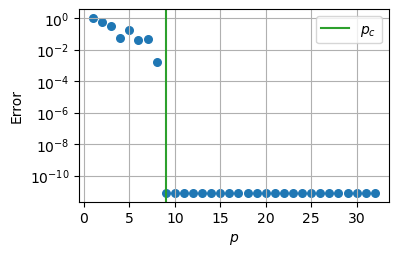

In [172]:
plt.figure(figsize=(4, 2.5))
plt.scatter(arange(p_min, p_max + 1), errors, s=30)
plt.axvline(p_c, label=r"$p_c$", color="tab:green")
plt.xlabel(r"$p$")
plt.ylabel("Error")
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

# k-SAT

In [41]:
### SAT instances and Hamiltonians ###

def gen_ksat_instance(n, m, k):
    clauses = []
    i = 0
    c = 0
    while i < m and c < 500:
        a = sort(choice(arange(1, n + 1), k, replace=False))
        b = choice([-1, 1], k, replace=True)
        clause = list(a*b)
        if clause not in clauses:
            clauses.append(clause)
            i += 1
        c += 1
    if c == 500:
        print(f"Can't generate {m} unique clauses, returned {len(clauses)}!")
    return clauses

def ksat_to_ham_diag(n, clauses):
    d = 2**n
    H_diag = zeros(d)
    for clause in clauses:
        op = [array([1, 1])]*n
        for var in clause:
            if sign(var) == 1:
                op[abs(var) - 1] = array([1, 0])
            else:
                op[abs(var) - 1] = array([0, 1])
        op = reduce(kron, op)
        H_diag += op
    return H_diag

In [6]:
n = 5
p_min = 1
p_max = 2**n

d = 2**n
x_list = mixer_list(n)
state_ini = full(d, 1/sqrt(d))

In [7]:
k = 2
m = 10

clauses = gen_ksat_instance(n, m, k)
H_diag = ksat_to_ham_diag(n, clauses)
cost_min_exact = min(H_diag)

p_c = int(find_qaoa_eqd(x_list, n, H_diag, state_ini, tol=None, verbose=True)/2)

p_c:    31 | QFIM rank:    62

In [18]:
np.random.seed(42)
gen_ksat_instance(n, 7, k)

[[2, -5], [-1, -4], [2, 5], [4, 5], [3, 5], [-2, -3], [1, -5]]

In [180]:
funs = zeros(p_max - p_min + 1)
errors = zeros(p_max - p_min + 1)
nits = zeros(p_max - p_min + 1)
nfevs = zeros(p_max - p_min + 1)
xfs = [zeros(2*p) for p in range(p_min, p_max + 1)]
times = zeros(p_max - p_min + 1)

fvals = []
fval_cont = [None]

x0 = uniform(0, 2*pi, 2*p_min)

c = 0
for p in range(p_min, p_max + 1):
    print("\tp:", p)
    
    time_start = time()
    result = minimize(x0=x0, fun=fun, callback=callback, method="BFGS")
    time_finish = time() - time_start
    xf = result.x
    error = abs(cost_min_exact - result.fun)

    print("\n\t\tFinished in %d seconds" %time_finish)
    print("\t\tError: %.9f" %error)
    
    funs[c:] = result.fun
    errors[c:] = error
    nits[c] = result.nit
    nfevs[c] = result.nfev
    times[c] = time_finish
    xfs[c] = result.x

    if abs(cost_min_exact - result.fun) <= 1e-8:
        print("Converged!")
        break
    else:
        c += 1
        x0 = concatenate([xf, uniform(0, 2*pi, 2)]) # simple initialization p -> p+1 random initialization
        ### interpolation initialization ###
        # gammas = result.x[::2]
        # betas = result.x[1::2]
        # gammas_next = zeros(p + 1)
        # betas_next = zeros(p + 1)
        # for j in range(p + 1):
        #     gammas_next[j] = j/p*gammas[j - 1] + (p - j)/p*gammas[j % p]
        #     betas_next[j] = j/p*betas[j - 1] + (p - j)/p*betas[j % p]
        # x0 = zeros(2*(p + 1))
        # x0[::2] = gammas_next
        # x0[1::2] = betas_next

	p: 1

		Finished in 0 seconds
		Error: 1.029038428
	p: 2
		Iteration: 20 | Cost: 0.91419111
		Finished in 0 seconds
		Error: 0.809668127
	p: 3
		Iteration: 40 | Cost: 0.64488163
		Finished in 0 seconds
		Error: 0.644880501
	p: 4
		Iteration: 60 | Cost: 0.57414566
		Finished in 0 seconds
		Error: 0.574144715
	p: 5
		Iteration: 80 | Cost: 0.43648469
		Finished in 0 seconds
		Error: 0.436483541
	p: 6
		Iteration: 110 | Cost: 0.39178352
		Finished in 0 seconds
		Error: 0.391783515
	p: 7
		Iteration: 160 | Cost: 0.28025092
		Finished in 0 seconds
		Error: 0.280250629
	p: 8
		Iteration: 190 | Cost: 0.15885018
		Finished in 0 seconds
		Error: 0.158662978
	p: 9
		Iteration: 250 | Cost: 0.06539541
		Finished in 0 seconds
		Error: 0.065395055
	p: 10
		Iteration: 380 | Cost: 0.07454151
		Finished in 0 seconds
		Error: 0.074541327
	p: 11
		Iteration: 490 | Cost: 0.09002796
		Finished in 0 seconds
		Error: 0.090027602
	p: 12
		Iteration: 820 | Cost: 0.00000114
		Finished in 2 seconds
		Error: 0.00

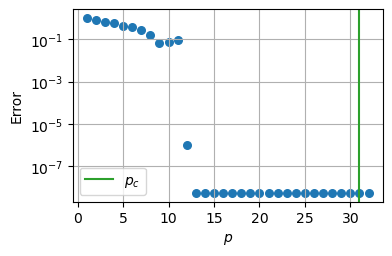

In [181]:
plt.figure(figsize=(4, 2.5))
plt.scatter(arange(p_min, p_max + 1), errors, s=30)
plt.axvline(p_c, label=r"$p_c$", color="tab:green")
plt.xlabel(r"$p$")
plt.ylabel("Error")
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()